# 🏀 EuroLeague Players Scouting – ML Project

**Authors**: Alessandro Frullo, Giulia Pareschi  
**University**: University of Bologna

---

This project provides a complete machine learning pipeline for scouting and forecasting emerging talent in the EuroLeague.  
By analyzing detailed player-season statistics, the system identifies breakout trajectories and predicts future high-impact players.

The workflow integrates unsupervised clustering, trajectory-based pseudo-labeling, and supervised predictive modeling to generate interpretable and data-driven scouting insights.  
Its modular structure supports end-to-end automation—from messy Excel sheets to ranked predictions and interactive dashboards for decision-making.

A special thanks to [Hackastat](https://hackastat.eu/en/home-page-eng/) guys for making high-quality EuroLeague data available, and to the [EuroLeague](https://www.euroleaguebasketball.net/euroleague/) organization for enabling such impactful analytics work.

In [1]:
import os
import pandas as pd

import utils.phase0_tools as pt0
import utils.phase1_tools as pt1
import utils.phase2_tools as pt2
import utils.phase3_tools as pt3
import utils.phase4_tools as pt4
import utils.phase5_tools as pt5

## 📂 Phase 0 - Raw Data Extraction and Unification

**Goal:**  
Convert raw, unstructured Excel stat sheets into standardized datasets ready for machine learning.

### 📥 Input
- Selected seasonal `.xlsx` file (e.g., `24_25`)
- Always-included all-time stats:
  - Traditional statistics
  - Advanced statistics

### ⚙️ Process
- Optionally downloads the selected seasonal file from Google Drive
- Locates and extracts valid stat tables from messy Excel layouts
- Applies consistent column naming (seasonal only)
- Filters out incomplete or irrelevant rows
- Merges all-time traditional and advanced stats into a unified dataset
- Saves all outputs in both `.xlsx` and `.pkl` formats

### 📦 Output
- Cleaned seasonal stats file (e.g., `24_25_Players_stats_clean`)
- Merged all-time dataset (`All_time_Players_stats_merged`)
- Standardized format across all outputs

---

### 🧰 Tools Used

| Task              | Tool              |
|-------------------|-------------------|
| Excel Handling    | `openpyxl`        |
| Data Processing   | `pandas`, `tqdm`  |
| File Downloading  | `gdown`           |
| Output Formats    | `.xlsx`, `.pkl`   |


In [2]:
in_dataset_dir = 'src/raw'     # Directory containing the original raw Excel files (uncleaned statistics)
out_dataset_dir = 'src/clean'  # Directory where cleaned, structured .xlsx and .pkl files will be saved

# Executes the preprocessing pipeline from Phase 0:, uncomment for first execution
# pt0.process_table(in_dataset_dir, out_dataset_dir, "24_25")

In [3]:
alltime_trad_path = os.path.join(out_dataset_dir, "All_time_Players_trad_stats_clean.xlsx")
alltime_adv_path = os.path.join(out_dataset_dir, "All_time_Players_adv_stats_clean.xlsx")
alltime_path = os.path.join(out_dataset_dir, "All_time_Players_stats_merged.xlsx")
alltime_path_pkl = os.path.join(out_dataset_dir, "All_time_Players_stats_merged.pkl")

# Uncomment for first execution
# pt0.merge_alltime(alltime_trad_path, alltime_adv_path, alltime_path)

## 🧠 Phase 1 - Unsupervised Clustering of Player Seasons

**Goal:**  
Group EuroLeague player-seasons into performance tiers using unsupervised learning to form the foundation for long-term emergence tracking.

### 📥 Input
- Season-by-season EuroLeague player stats (2000-2021)
- Core features: `PTS/G`, `USG%`, `PER`, `TS%`, `W%`, `AGE`, etc.

### ⚙️ Process

1. **Filtering & Normalization**
   - Removed low-activity players (`GP < 10`, `Min/G < 5`)
   - Rank-normalized all stats (`pandas.rank(pct=True)`)

2. **PII Computation**
   - Calculated **Player Impact Index** as a weighted sum of rank-normalized features
   - Included youth bonus: `Is_Under = (AGE ≤ threshold)`

3. **Clustering**
   - Applied `KMeans` (`sklearn.cluster`) to normalized features
   - Assigned each season to a cluster (`n_clusters = 5`)

4. **PCA Visualization**
   - Used `PCA` (`sklearn.decomposition`) for 2D projection
   - Created interactive cluster plots with `plotly`

5. **Label Mapping**
   - Converted PII percentiles to qualitative labels:
     - `"Superstar"`, `"All-Star"`, `"Starter"`, `"Role Player"`, `"Bench"`

### 📦 Output
- Clustered dataset (`.pkl`, `.xlsx`) with:
  - `Cluster`, `Cluster_Label`, `PII`
- Interactive PCA plot (`.html`, `.png`)

---

### 🧰 ML Tools Used

| Task                  | Tool                          |
|-----------------------|-------------------------------|
| Normalization         | `pandas.rank(pct=True)`       |
| Clustering            | `sklearn.cluster.KMeans`      |
| Dimensionality Reduction | `sklearn.decomposition.PCA`|
| Visualization         | `plotly.graph_objects`        |
| Impact Scoring        | Custom PII function           |


In [4]:
# Profiles clustering
df_clustered = pt1.cluster_player_profiles(
    pkl_path="src/clean/All_time_Players_stats_merged.pkl",  # Path to cleaned all-time data
    n_clusters=5,         # Number of clusters for KMeans
    min_games=10,         # Filter: only consider players with ≥N games to reduce noise
    min_minutes=8,        # Filter: only consider players averaging >N minutes per game
    show_plots=True,      # Enable interactive PCA scatter plot visualization
    return_data=True      # Return the enriched DataFrame instead of saving it only
)

[INFO] Loading dataset from: src/clean/All_time_Players_stats_merged.pkl


[INFO] Clustered dataset saved to: src/clean


## 🔍 Phase 2 - Career Emergence Labeling (Pseudo-Labels)

**Goal:**  
Generate binary pseudo-labels for career emergence by analyzing players’ cluster evolution and impact trends over time.

### 📥 Input
- Clustered player-season data from Phase 1, including `Cluster`, `PII`, `SEASON`, `AGE`

### ⚙️ Process

1. **Trajectory Analysis**
   - Sorted each player’s career chronologically
   - Measured:
     - Cluster improvement (`max - min`)
     - PII slope and gain
     - Recovery after worst season
   - Labeled player `Is_Career_Emergent = 1` if:
     - Big cluster jump with recovery
     - Upward PII trend or high PII gain
     - Multiple `Cluster 0` seasons

2. **Trajectory Typing**
   - Assigned labels like: `"LowToHigh"`, `"MidToHigh"`, `"UpwardTrend"`, `"PIIonly"`, `"ConsistentlyTop"`

3. **Rookie Adjustment (Optional)**
   - Used `AGE` + `PII` to identify breakout rookies via logistic thresholding
   - Labeled as `"RookieImpact"`

4. **Emergence Score**
   - Computed per player:
     \[
     \text{Score} = \text{Cluster\_Improvement} \cdot \frac{\text{Mean + Max PII}}{1 + \text{Std PII}}
     \]

### 📦 Output
- Summary DataFrame with:
  - `Is_Career_Emergent`, `Trajectory_Type`, `Emergence_Score`
  - PII stats + career metadata
- Saved to `.pkl` and printable summary

---

### 🧰 ML Tools Used

| Task                  | Tool                            |
|-----------------------|---------------------------------|
| Trend Analysis        | `scipy.stats.linregress`        |
| Grouping & Diffing    | `pandas.groupby().diff()`       |
| Threshold Logic       | `utils.dynamic_emergent_label()`|
| Scoring & Ranking     | Custom formula                  |
| Data Handling         | `pandas`, `to_pickle`, `merge` |


In [5]:
# Career-based Labeling
df_emergents = pt2.extract_career_emergents(
    input_path="src/clean/All_time_Players_stats_clustered_labeled.pkl",  # Input: DataFrame with cluster & PII info
    output_path="src/clean/Career_Emergents.pkl",                         # Output: saves labeled summary DataFrame
    min_improvement=2,         # Minimum cluster improvement required (e.g., from cluster 4 to cluster 2)
    show_table=False,          # If True: print top emergents by score in console; False: skip printing
    include_top_rookies=True,  # Adds standout rookies based on dynamic thresholding (PII vs age curve)
    max_age_first_season=24    # Consider rookies only if their first season is under this age threshold
)

[INFO] Loading player-season data from: src/clean/All_time_Players_stats_clustered_labeled.pkl
[INFO] Emergence summary saved to: src/clean/Career_Emergents.pkl
[INFO] Players analyzed: 899
[INFO] Career-level emergents detected: 396 (44.05%)


In [6]:
# Print output df
df_emergents.sort_values(by="Mean_PII", ascending=False)

,NAME,Is_Career_Emergent,Cluster_Improvement,Worst_Cluster,Best_Year,Worst_Year,Trajectory_Type,Best_Cluster,First_Season,Mean_PII,Max_PII,Min_PII,Std_PII,Seasons_Played,Emergence_Score
485,Luka Doncic,True,3,4,2017-2018,2015-2016,LowToHigh,1,2015-2016,-2.8915,-2.8431,-2.9271,0.0435,3,-16.487
839,Usman Garuba,True,2,2,2020-2021,2019-2020,MidToHigh,0,2019-2020,-3.1836,-2.9359,-3.4314,0.3504,2,-9.063
705,Ricky Rubio,False,1,4,2009-2010,2006-2007,NoChange,3,2006-2007,-3.3253,-2.9627,-3.6394,0.3409,3,0.000
292,Furkan Korkmaz,False,0,4,2015-2016,2014-2015,NoChange,4,2014-2015,-3.3366,-3.2001,-3.4731,0.1930,2,0.000
614,Nicolas Batum,False,1,1,2006-2007,2007-2008,NoChange,0,2006-2007,-3.3708,-3.2942,-3.4474,0.1083,2,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Thierry Gadou,False,0,4,2005-2006,2004-2005,NoChange,4,2004-2005,-7.0957,-6.9441,-7.2473,0.2144,2,0.000
169,Damir Mrsic,False,2,3,2006-2007,2007-2008,NoChange,1,2006-2007,-7.1979,-6.9167,-7.3977,0.2506,3,0.000
12,Ainars Bagatskis,False,1,4,2004-2005,2003-2004,NoChange,3,2003-2004,-7.2016,-7.0856,-7.3175,0.1640,2,0.000
616,Nicolas Mazzarino,False,0,4,2012-2013,2011-2012,NoChange,4,2011-2012,-7.3406,-7.1385,-7.5428,0.2859,2,0.000


## 🧠 Phase 3 - Supervised Dataset Construction

**Goal:**  
Build a training-ready dataset of player-season features with labels derived from emergence trajectories.

### 📥 Input
- Player-season stats from Phase 1  
- Pseudo-labels (`Is_Career_Emergent`, `Best_Year`) from Phase 2

### ⚙️ Process

1. **Feature Selection**
   - Season-level metrics: `PTS/G`, `USG%`, `PER`, `AGE`, etc.
   - Contextual flags: `Is_Under`, `Is_U20`

2. **Temporal Deltas**
   - Added year-over-year changes: `Δ_PTS/G`, `Δ_PER`, `Δ_USG%`

3. **Label Modes**
   - `"seasonal"`: label = 1 if emergence occurs in `t+1`
   - `"career"`: label = 1 if season ≤ `Best_Year`

4. **Filtering**
   - Removed outliers (`PER > 40`, `NET RTG > 100`)
   - Optional: `max_age` cutoff

5. **Dataset Output**
   - `X_features`: full feature matrix  
   - `y_labels`: binary label vector (0 or 1)

6. **Optional Visualization**
   - `plot_top_players_by_metric()` to explore metric vs `AGE` with label color

### 📦 Output
- Feature matrix + labels: ready for Phase 4 model training
- Optional scatter plot to inspect label/feature dynamics

---

### 🧰 ML Tools Used

| Task                  | Tool                          |
|-----------------------|-------------------------------|
| Feature Engineering   | `pandas`, `.diff()`           |
| Label Assignment      | Custom logic per mode         |
| Filtering & Scaling   | `pandas`, `to_numeric`        |
| Visualization         | `plotly.graph_objects`        |


In [7]:
# Supervised Dataset Creation
X_features, y_labels = pt3.build_supervised_dataset(
    pkl_path="src/clean/All_time_Players_stats_clustered_labeled.pkl",  # Input dataset with PII, clusters, stats
    df_emergents=df_emergents,        # DataFrame containing emergent players and their breakout seasons
    # max_age=28,                     # Exclude player-seasons with AGE > max_age (disabled)
    young_age_threshold=23,           # Age threshold to define binary flag 'Is_Under' (e.g., U23 indicator)
    label_mode="seasonal"               # Labeling logic:
                                      #  - "seasonal": emergence in next season (t+1)
                                      #  - "career": emergence occurs before or in best season
)

In [8]:
print(f"Emergent players: {y_labels.sum()} / {len(y_labels)} ({y_labels.mean() * 100:.2f}%)")
X_features[y_labels].sort_values("PII", ascending=False)

Emergent players: 177 / 1402 (12.62%)


,NAME,SEASON,PII,TEAM,Cluster,Cluster_Label,PTS/G,USG%,Min/G,TS%,...,NET RTG,W%,AST/TO,AST%,TO Ratio,DEF RTG,ST%,BLK%,TR%,AGE
3688,Luka Doncic,2016-2017,-2.8431,RMB,3,Superstar / MVP Candidate,8.28,0.206469,19.51,0.612299,...,16.44,0.76,2.45,33.30,15.41,105.42,2.38,0.88,13.09,18.0
3853,Marco Belinelli,2005-2006,-3.2932,FOR,1,Superstar / MVP Candidate,13.37,0.20674,27.93,0.618005,...,12.04,0.58,0.79,6.39,9.64,107.83,2.65,0.00,3.42,20.0
735,Beno Udrih,2001-2002,-3.3776,COL,1,Superstar / MVP Candidate,10.79,0.194316,27.34,0.514296,...,-0.26,0.47,1.32,17.75,13.97,106.57,3.83,0.33,6.14,20.0
4351,Milenko Tepic,2007-2008,-3.7056,PAR,1,Superstar / MVP Candidate,8.70,0.181395,26.28,0.537091,...,-7.08,0.50,0.98,14.67,17.69,109.37,1.51,0.35,8.15,21.0
5949,Stefano Mancinelli,2004-2005,-3.7210,FOR,3,Superstar / MVP Candidate,6.32,0.149453,17.92,0.739552,...,24.13,0.79,1.73,13.23,10.66,111.77,2.08,1.13,9.89,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,Marcelinho Huertas,2017-2018,-6.8180,BSK,4,Low Impact / Bench,5.48,0.203214,15.45,0.480869,...,-29.38,0.44,2.26,31.77,20.99,121.74,0.34,0.00,3.44,35.0
3320,Kerem Gonlum,2012-2013,-6.8315,EFS,0,Low Impact / Bench,6.00,0.168011,18.56,0.58472,...,3.84,0.58,0.60,6.05,14.80,104.90,1.47,0.77,14.50,36.0
5708,Sergey Monia,2018-2019,-6.9086,KHI,4,Low Impact / Bench,4.12,0.175581,12.32,0.590325,...,-26.18,0.31,1.44,15.75,13.31,118.85,1.90,2.76,8.05,36.0
5013,Paulius Jankunas,2019-2020,-7.0012,ZAL,4,Low Impact / Bench,3.00,0.151976,13.68,0.435314,...,-13.21,0.44,1.50,9.38,11.33,111.74,1.42,0.61,14.00,36.0


In [9]:
# Generate an interactive scatter plot comparing top players by metric vs age
pt3.plot_top_players_by_metric(
    X_features, y_labels,
    metrics=["PII", "PER", "PTS/G", "NET RTG", "W%"],   # Metrics to visualize on Y-axis
    cutoff=100                                          # Top-N players per metric to include in each scatter
)

[INFO] Saved interactive plot to: img


## 🤖 Phase 4 - Supervised Model Training

**Goal:**  
Train ML classifiers to predict player emergence using features and pseudo-labels from Phases 2-3.

### 📥 Input
- `X_features`: Season-level metrics  
- `y_labels`: Binary pseudo-labels (0/1 for emergence)

### ⚙️ Process

1. **Model Selection**
   - Supported: `RandomForest`, `LogisticRegression`, `XGBoost`
   - Two modes:
     - `simple`: predefined params
     - `optimized`: `GridSearchCV` with cross-validation

2. **Training Pipeline**
   - `train_test_split` with stratification
   - Optional: **SMOTE** for class balancing
   - `StandardScaler` applied for `logreg`

3. **Threshold Optimization**
   - Compute best `F1-score` threshold from `precision_recall_curve`

4. **Evaluation**
   - Reports: `classification_report`, `AUC-ROC`, class balance
   - Saves predictions with `prob_emergent` and `y_pred`

5. **Feature Importance**
   - `feature_importances_` (RF/XGB) or `coef_` (LogReg)
   - Plotted (top 10) and saved to `.xlsx`

6. **Model Comparison**
   - Interactive dropdown: `AGE` vs `prob_emergent` across models
   - Bar plots of `F1`, `Precision`, `Recall`, `AUC`

### 📦 Output
- Trained model: `.joblib`  
- Feature list: `.txt`  
- Results: `.pkl` + `.xlsx`  
- Plots: `.html`, `.png`

---

### 🧰 ML Tools Used

| Task               | Tool                          |
|--------------------|-------------------------------|
| Models             | `sklearn`, `xgboost`          |
| Tuning             | `GridSearchCV`                |
| Balancing          | `imblearn.SMOTE`              |
| Metrics            | `roc_auc_score`, `precision_recall_curve` |
| Visualization      | `matplotlib`, `plotly`        |
| Model persistence  | `joblib`, `pandas.to_excel`   |
<!--  -->

In [10]:
# Model Training and Evaluation (Simple Version)
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

results_models = {}                 # Stores prediction results for each model
feature_importances = {}            # Stores feature importance per model
model_metrics = {}                  # Stores evaluation scores (F1, Precision, etc.)
models = ['rf', 'xgb', 'logreg']    # Models to train: Random Forest, XGBoost, Logistic Regression

[TRAINING] Model: RF

[INFO] Model and features saved in 'models/rf'
[INFO] Optimal threshold for F1: 0.350 (F1 = 0.2556)
[INFO] Model: RF | Threshold: 0.35
              precision    recall  f1-score   support

       False       0.90      0.72      0.80       368
        True       0.18      0.43      0.26        53

    accuracy                           0.68       421
   macro avg       0.54      0.58      0.53       421
weighted avg       0.81      0.68      0.73       421

[INFO] AUC-ROC: 0.5771
[INFO] Top 10 Feature Importances:
Feature  Importance
   BLK%    0.086622
   AST%    0.079345
DEF RTG    0.075704
     W%    0.073577
    ST%    0.073276
NET RTG    0.070587
    PER    0.070218
    TR%    0.069612
  Min/G    0.062718
 AST/TO    0.062640
[INFO] Feature importance plot saved to: models/rf\feature_importance_rf.png


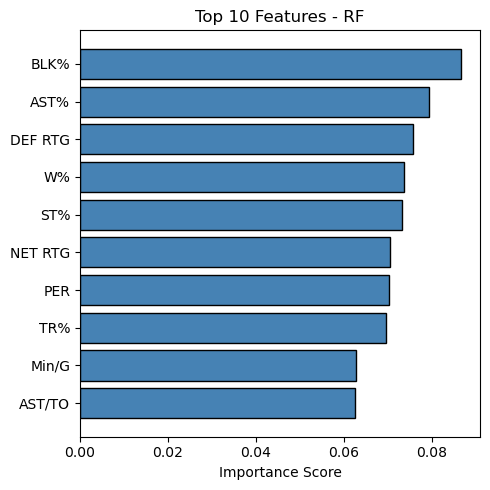

[INFO] Feature importance saved to: models/rf\feature_importance_rf.xlsx
------------------------------------------------------------
[TRAINING] Model: XGB

[INFO] Model and features saved in 'models/xgb'
[INFO] Optimal threshold for F1: 0.007 (F1 = 0.2473)
[INFO] Model: XGB | Threshold: 0.01
              precision    recall  f1-score   support

       False       0.93      0.28      0.43       368
        True       0.14      0.85      0.25        53

    accuracy                           0.35       421
   macro avg       0.54      0.56      0.34       421
weighted avg       0.83      0.35      0.40       421

[INFO] AUC-ROC: 0.5474
[INFO] Top 10 Feature Importances:
Feature  Importance
   BLK%    0.102518
     W%    0.087413
NET RTG    0.081010
DEF RTG    0.075641
    ST%    0.072105
  Min/G    0.069948
   USG%    0.061219
   AST%    0.061108
    PER    0.061073
    TS%    0.060860
[INFO] Feature importance plot saved to: models/xgb\feature_importance_xgb.png


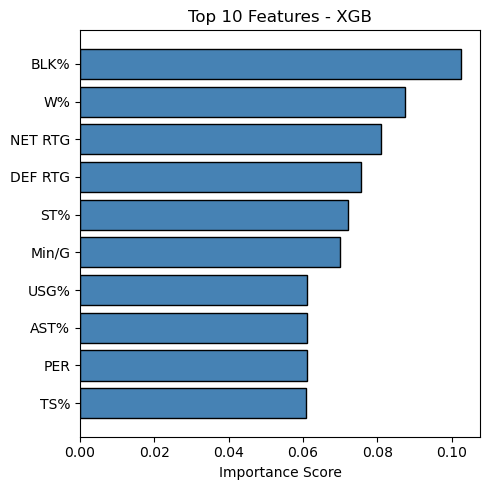

[INFO] Feature importance saved to: models/xgb\feature_importance_xgb.xlsx
------------------------------------------------------------
[TRAINING] Model: LOGREG

[INFO] Model and features saved in 'models/logreg'
[INFO] Optimal threshold for F1: 0.482 (F1 = 0.3030)
[INFO] Model: LOGREG | Threshold: 0.48
              precision    recall  f1-score   support

       False       0.93      0.61      0.74       368
        True       0.20      0.66      0.30        53

    accuracy                           0.62       421
   macro avg       0.56      0.64      0.52       421
weighted avg       0.83      0.62      0.68       421

[INFO] AUC-ROC: 0.6299
[INFO] Top 10 Feature Importances:
 Feature  Importance  Coefficient
   PTS/G    0.878932    -0.878932
     TS%    0.626459     0.626459
    USG%    0.524222     0.524222
 NET RTG    0.474563    -0.474563
      W%    0.440883    -0.440883
     ST%    0.349304    -0.349304
TO Ratio    0.307010    -0.307010
   Min/G    0.287995     0.287995
    

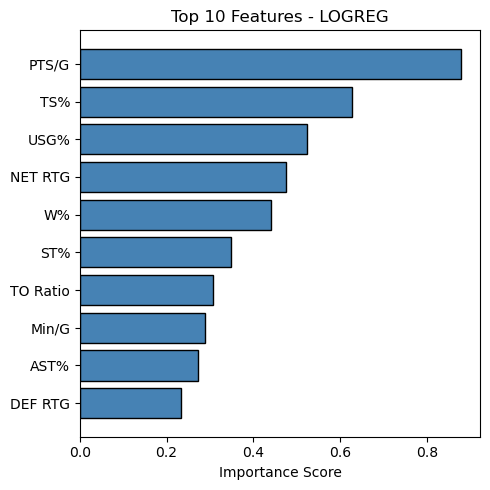

[INFO] Feature importance saved to: models/logreg\feature_importance_logreg.xlsx
------------------------------------------------------------


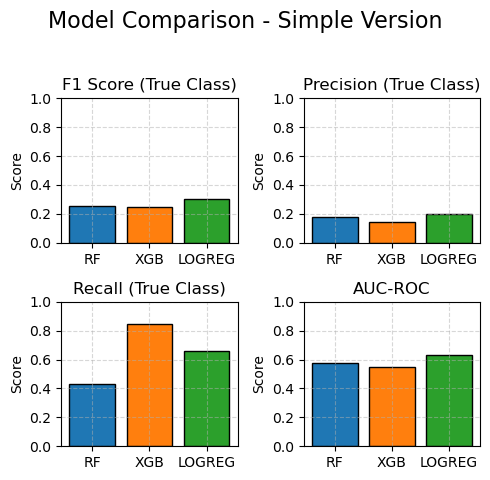

In [11]:
# Loop through each model and train it, then evaluate and confront results
for model in models:
    print(f"[TRAINING] Model: {model.upper()}\n")

    results, feat_imp = pt4.train_and_evaluate_model_simple(
        X_features=X_features,            # Input features from Phase 3
        y_labels=y_labels,                # Binary labels (emergent or not)
        model_name=model,                 # Which model to train
        use_smote=True,                   # Apply SMOTE to balance minority class
        optimize_threshold=True,          # Adjust decision threshold to maximize F1 score
        save_model_path=f"models/{model}" # Save trained model and feature list to disk
    )

    print("-" * 60)

    # Store results and compute metrics
    if not results.empty:
        results_models[model] = results

        y_true = results["y_true"]
        y_pred = results["y_pred"]
        y_prob = results["prob_emergent"]

        # Compute core evaluation metrics
        model_metrics[model.upper()] = {
            "F1_True": f1_score(y_true, y_pred),
            "Precision_True": precision_score(y_true, y_pred),
            "Recall_True": recall_score(y_true, y_pred),
            "AUC_ROC": roc_auc_score(y_true, y_prob),
            "Accuracy": accuracy_score(y_true, y_pred)
        }

    # Store feature importance (if available)
    if feat_imp is not None and not feat_imp.empty:
        feature_importances[model] = feat_imp

# Visualize model performance
pt4.plot_model_comparison_bars(
    model_metrics,
    title="Model Comparison - Simple Version"
)

In [12]:
# Generates an interactive scatter plot comparing predicted emergence probabilities across trained models (RF, XGB, LogReg) 
pt4.plot_model_comparison_dropdown(results_models)

[INFO] Saved dropdown plot to img/model_comparisons


## 🔮 Phase 5 - Model Application & Scouting Output

**Goal:**  
Apply the trained ML model to current season data to predict breakout candidates for the upcoming season.

### 📥 Input
- Preprocessed player data (e.g., 2024-25)
- Trained model (`.joblib`) and feature list (`model_features.txt`)

### ⚙️ Process

1. **Preprocessing**
   - Infer `SEASON` from filename
   - Drop `GP < 5` and `AGE > 45`
   - Compute `PII` and percentile ranks
   - Add `Is_U20` flag

2. **Prediction**
   - Load model and expected features
   - Scale data if needed (`logreg`)
   - Predict `prob_emergent` using `predict_proba()`

3. **Dynamic Thresholding**
   - Apply logistic function to compute age-based threshold:
     \[
     T(age) = p_{min} + \frac{p_{max} - p_{min}}{1 + e^{-k(age - x_0)}}
     \]
   - Label as `emergent = True` if `prob ≥ T(age)`

4. **Output**
   - Save predictions to `.xlsx` / `.pkl`
   - Include: `NAME`, `AGE`, `TEAM`, `prob_emergent`, `predicted_emergent`
   - Sort descending by probability

5. **Visualization**
   - Generate interactive scatter plot (`AGE` vs `prob_emergent`) with dropdown:
     - All / Emerging / Not Emerging

### 📦 Output
- Cleaned dataset: `*_preprocessed.pkl/.xlsx`
- Predictions: `*_predictions.pkl/.xlsx`
- Interactive plot: `.html` + `.png`

---

### 🧰 ML Tools Used

| Step               | Tool                        |
|--------------------|-----------------------------|
| Prediction         | `joblib`, `predict_proba()` |
| Thresholding       | Logistic function (`numpy`) |
| Preprocessing      | `pandas`, `rank(pct=True)`  |
| Visualization      | `plotly.graph_objects`      |
| Export             | `to_excel`, `to_pickle`     |


In [13]:
# Current Season Preprocessing
df_2425 = pt5.preprocess_season_dataset(
    path_input=os.path.join(out_dataset_dir, "24_25_Players_stats_clean.pkl"),     # Input: cleaned 2024–25 raw stats
    path_reference=os.path.join(out_dataset_dir, "All_time_Players_stats_clustered_labeled.pkl"),  # Reference schema with PII/clusters
    output_dir="output",                  # Folder to save preprocessed Excel and Pickle files
    verbose=True                          # Print status logs to understand filters, season parsed, etc.
)

[INFO] Season inferred from filename: 2024-2025
[INFO] Removed 42 players with GP < 5
[INFO] Saved preprocessed data to: output


In [14]:
# Applying Trained Model to Current Season
df_preds = pt5.apply_trained_model_to_season(
    input_path="output/24_25_Players_stats_clean_preprocessed.pkl", # Input: preprocessed 2024–25 season dataset
    output_path="output/emergents_2024_2025",                       # Output: prediction results (.xlsx + .pkl)
    model_name="rf",                                                # Model to use: 'rf', 'xgb', or 'logreg'
    models_dir="models/rf",                                         # Path to trained model + feature list

    # Alternative models (uncomment to use):
    # model_name="xgb",
    # models_dir="models/xgb",
    # model_name="logreg",
    # models_dir="models/logreg",

    optimize_threshold=True,     # Automatically adjust threshold to maximize F1 (dynamic if AGE < 32)
    verbose=True                 # Print logs during model loading, filtering, and prediction
)

[INFO] Model loaded from: models/rf\model_rf.joblib
[INFO] Data loaded from: output/24_25_Players_stats_clean_preprocessed.pkl
[INFO] Predictions saved to:
       - output/emergents_2024_2025.xlsx
       - output/emergents_2024_2025.pkl


In [15]:
df_preds

,NAME,AGE,SEASON,TEAM,prob_emergent,predicted_emergent
2,Malte Delow,24,2024-2025,ALBA Berlin,0.50,True
11,Louis Olinde,27,2024-2025,ALBA Berlin,0.50,True
196,Tyler Dorsey,29,2024-2025,Olympiacos Piraeus,0.50,True
307,Alen Smailagic,25,2024-2025,Zalgiris Kaunas,0.48,True
182,Wenyen Gabriel,28,2024-2025,Maccabi Playtika Tel Aviv,0.48,True
...,...,...,...,...,...,...
202,Shaquielle McKissic,35,2024-2025,Olympiacos Piraeus,0.19,False
234,Kevarrius Hayes,28,2024-2025,Paris Basketball,0.19,False
149,Nigel Hayes Davis,31,2024-2025,Fenerbahce Beko Istanbul,0.18,False
260,Frank Ntilikina,27,2024-2025,Partizan Mozzart Bet Belgrade,0.18,False


In [16]:
# Generates an interactive scatter plot of model predictions for the 2024–2025 season.
# Each point represents a player, colored by predicted emergence.
pt5.plot_emergent_predictions_interactive(df_preds)

[INFO] Interactive plot saved to:
       - img\emergent_predictions_interactive.html
       - img\emergent_predictions.png


## 📚 References

### Data Sources
- [EuroLeague All-Time Stats (2000–2021) – Hack a Stat](https://hackastat.eu/en/euroleague-stats/euroleague-all-time-stats-league-averages/)
- [EuroLeague Season Stats (2023–2024) – Hack a Stat](https://hackastat.eu/en/euroleague-stats/euroleague-stats-2023-2024/)
- [EuroLeague Season Stats (2024–2025) – Hack a Stat](https://hackastat.eu/en/euroleague-stats/euroleague-stats-2024-2025/)

### Machine Learning Tools
- [scikit-learn – Machine Learning in Python](https://scikit-learn.org/stable/)  
  Used for clustering, classification models, cross-validation, and metrics.
- [XGBoost – Scalable Gradient Boosting](https://xgboost.readthedocs.io/en/stable/)  
  Used for advanced supervised learning with gradient boosting.
- [imblearn – Imbalanced-learn Toolkit](https://imbalanced-learn.org/stable/)  
  Used for class rebalancing via SMOTE during model training.
- [pandas – Data Analysis Library](https://pandas.pydata.org/)  
  Used throughout for data cleaning, transformation, and export.
- [NumPy – Scientific Computing](https://numpy.org/)  
  Used for vectorized math and logistic function implementations.
- [Plotly – Interactive Visualizations](https://plotly.com/python/)  
  Used for PCA visualizations, metric dashboards, and scouting plots.

### Language Model Support
- [ChatGPT – OpenAI](https://chat.openai.com/)  
  Used to support idea generation, code review, and documentation writing.
